In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import normalize

from numpy import loadtxt
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
%matplotlib inline


In [127]:
# checking for paths
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


dataset\application_test.csv
dataset\application_train.csv
dataset\bureau.csv
dataset\bureau_balance.csv
dataset\credit_card_balance.csv
dataset\HomeCredit_columns_description.csv
dataset\installments_payments.csv
dataset\POS_CASH_balance.csv
dataset\previous_application.csv
dataset\sample_submission.csv


In [128]:
application_test=pd.read_csv("dataset/application_test.csv")
print("Testing Data: %s rows and %s cols"%application_test.shape)
application_train=pd.read_csv("dataset/application_train.csv")
print("Training Data: %s rows and %s cols"%application_train.shape)
# credit_balance = pd.read_csv('dataset/credit_card_balance.csv')
# print("Credit Card Balance: %s rows and %s cols"%credit_balance.shape)
# installments_payments = pd.read_csv('dataset/installments_payments.csv')
# print("Installments Payments: %s rows and %s cols"%installments_payments.shape)
# bureau = pd.read_csv('dataset\Bureau.csv')
# print("Bureau: %s rows and %s cols" %bureau.shape)
# bureau_balance = pd.read_csv('dataset\Bureau_balance.csv')
# print("Bureau train = application_train.copy()Balance: %s rows and %s cols" %bureau_balance.shape)
# POS_CASH_balance = pd.read_csv('dataset\POS_CASH_balance.csv')
# print("POS CASH Balance: % s rows and %s cols" % POS_CASH_balance.shape)
# previous_application = pd.read_csv('dataset\previous_application.csv')
# print("Previous Application: % s rows and %s cols" %previous_application.shape)
# sample_submission = pd.read_csv('dataset\sample_submission.csv')
# print("Sample Submission: % s rows and %s cols" %sample_submission.shape)

Testing Data: 48744 rows and 121 cols
Training Data: 307511 rows and 122 cols


In [129]:
train = application_train.copy()
train = train.sample(100000, random_state=50)

In [130]:
def calc_iv(df, feature, target, pr=0):

    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    if pr == 1:
        print(data)

    return data['IV'].values[0]

In [131]:

train
train_labels = train.pop('TARGET')

inf


C:\Users\Gaurav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [132]:
def encodeLabel(df):
    label_encoder = LabelEncoder()
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in categorical_cols:
        df[col] = label_encoder.fit_transform(df[col])

    return df

In [133]:
train = encodeLabel(train)

In [134]:
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
# imputer=IterativeImputer(verbose=2)
scaler = MinMaxScaler(feature_range= (0,1))

In [135]:
imputer.fit(train)
train = imputer.transform(train)


In [136]:
#noramlization



In [137]:
scaler.fit(train)
train = scaler.transform(train)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.2, random_state=50)

In [139]:
model=XGBClassifier(use_label_encoder=False)
model.fit(X_train,y_train)

[21:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [140]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [141]:
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.03%


In [142]:
y_score = model.predict_proba(X_test)[:,1]

In [143]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score)


In [144]:

print('ROC AUC Score: {}'.format(metrics.roc_auc_score(y_test,y_score)))

ROC AUC Score: 0.7280772169660739


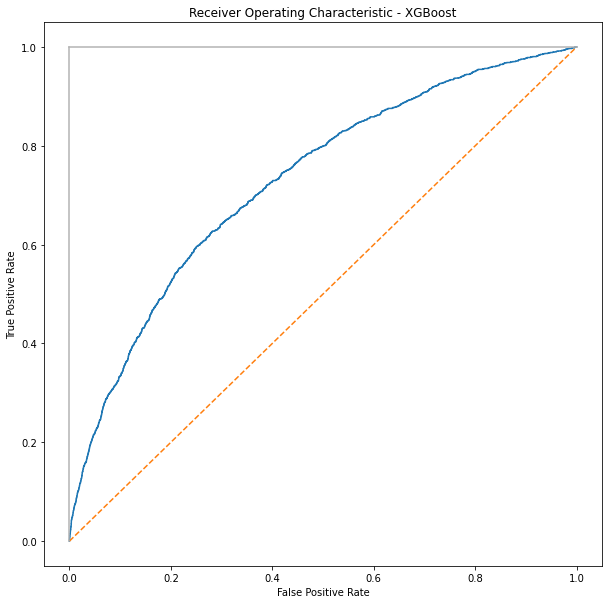

In [145]:
plt.subplots(1, figsize=(10, 10))
plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [146]:
results = confusion_matrix(y_test,y_pred)
print(results)

[[18347    70]
 [ 1523    60]]


In [147]:
# from sklearn.model_selection import cross_val_score
# n_folds = 10
# scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='roc_auc', n_jobs=-1)
# fold_names = list(range(n_folds))
# fold_names.append('Average')

# avg_score = scores.mean()
# scores = list(scores)
# scores.append(avg_score)
# cv_score = pd.DataFrame({'Fold Index': fold_names, 'ROC AUC (Norm)': scores, })

# cv_score